<a href="https://colab.research.google.com/github/irbaadika/Malnutrition_Analysis/blob/main/Malnutrition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Mount to drive

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import max
import matplotlib.pyplot as plt

In [54]:
spark = SparkSession.builder.appName("MalnutritionAnalysis").getOrCreate()

In [55]:
data = spark.read.csv("/content/drive/MyDrive/Big Data/PROJECT/WorldMalnutrition.csv", header=True, inferSchema=True)
data.head()

Row(Country='Afghanistan', Indicator='Under-five mortality rate', Sex='Female', TIME_PERIOD=2010, OBS_VALUE=84.17642561, Unit of Measure='Deaths per 1000 live births')

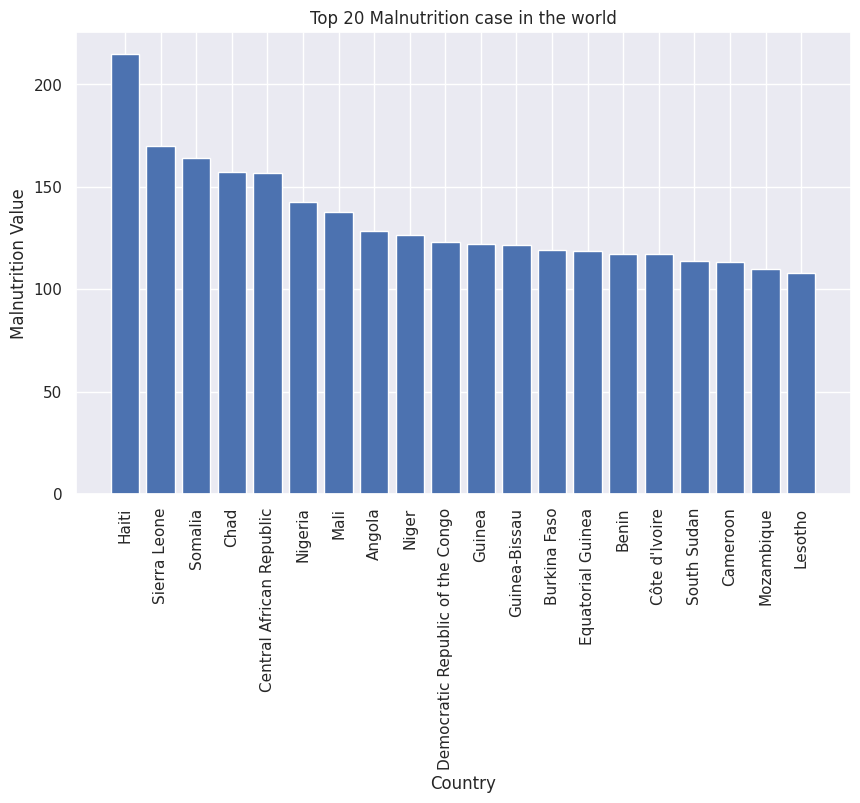

In [59]:
data_new= data.select("TIME_PERIOD", "Country", "Sex", "Indicator", "OBS_VALUE"). \
            withColumnRenamed("TIME_PERIOD", "time_period"). \
            withColumnRenamed("Country", "country"). \
            withColumnRenamed("Sex", "sex"). \
            withColumnRenamed("Indicator", "indicator"). \
            withColumnRenamed("OBS_VALUE", "obs_value")
data_new = data_new.filter((data_new["obs_value"].isNotNull()) & (data["obs_value"] >= 0))
data_new = data_new.withColumn("TIME_PERIOD", data_new["time_period"].cast("integer"))
max_obs = data_new.groupBy("country", "indicator").agg(max("obs_value").alias("max_obs_value"))
max_obs = max_obs.alias("max_obs")
data_new = data_new.alias("data_new")
result = max_obs.join(data_new,
		      (max_obs["indicator"] == data_new["data_new.indicator"]) &
		      (max_obs["country"] == data_new["data_new.country"]) &
                      (max_obs["max_obs.max_obs_value"] == data_new["data_new.obs_value"])
                     ).select( "max_obs.indicator", "data_new.country", "max_obs.max_obs_value")
result = result.orderBy("max_obs_value", ascending=False).limit(20)
result = result.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(result["country"], result["max_obs_value"])
plt.xlabel("Country")
plt.ylabel("Malnutrition Value")
plt.title("Top 20 Malnutrition case in the world")
plt.xticks(rotation=90)
plt.show()